In [1]:
from collections import namedtuple
from functools import partial
from inspect import signature
from itertools import product
from scipy.optimize import minimize_scalar
from scipy.stats import (
    bootstrap, entropy, f as fdist, 
    norm, pareto, shapiro, ttest_ind
)
from scipy.stats.mstats import trimboth, trimtail
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold
from sklearn.utils import resample
from vega_datasets import data
import altair as alt
import black
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sympy as sym

In [2]:
sns.set_theme(style='darkgrid')

In [3]:
def print_black(collection):
    print(black.format_str(repr(collection), mode=black.Mode()))

**Содержание**<a id='toc0_'></a>    
- [__Одномерный анализ__](#toc1_)    
  - [__Количественные признаки: распределение и гистограмма__](#toc1_1_)    
  - [__Дальнейшая суммаризация: центр и рассеяние__](#toc1_2_)    
    - [__Вычисление центра по критерию Минковского__](#toc1_2_1_)    
  - [__Бинарные и категоризованные признаки. Индекс Джини, энтропия__](#toc1_3_)    
  - [__Доверительный интервал бутстрэп-методом__](#toc1_4_)    
  - [__Перекрестная валидация (скользящий контроль)__](#toc1_5_)    
  - [__Решение заданий по темам главы__](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
# <a id='toc1_'></a>[__Одномерный анализ__](#toc0_)

***
## <a id='toc1_1_'></a>[__Количественные признаки: распределение и гистограмма__](#toc0_)

Одномерные данные (1D-данные) представляют собой набор объектов, описанных 
с помощью какого-либо одного признака, качественного или количественного. 
В этом случае нет смысла говорить о коррелировании — будут рассмотрены
методы суммаризации. __Не существует простого критерия, по которому можно
было бы определить, является ли признак качественным или количественным.
С практической точки зрения полезен следующий критерий: признак — количественный, 
если его среднее значение имеет смысл.__ Рассмотрим сначала случай,
когда признак — количественный.

Самый понятный и исчерпывающий способ агрегирования — это распределение, 
представленное так называемой __гистограммой__. На оси признака $x$ отмечают
границы, в которых изменяется признак, т.е. его минимальное и максимальное
значения на имеющихся объектах. Отмеченный интервал, называемый также __размахом 
признака__, делят на некоторое число непересекающихся интервалов одинаковой 
длины, так называемых бинов. Затем подсчитывают, сколько
объектов попадает в каждый отдельный бин, и рисуют столбики высотой, соответствующей 
числу объектов в бине.

[__sklearn.datasets.load_iris__](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn-datasets-load-iris)

In [4]:
X, y = load_iris(return_X_y=True, as_frame=True)
X.head()  # sepal - чашелистик, petal - лепесток

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
y.value_counts()

0    50
1    50
2    50
Name: target, dtype: int64

[__matplotlib.pyplot.hist__](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib-pyplot-hist) | [__seaborn.histplot__](https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn-histplot)

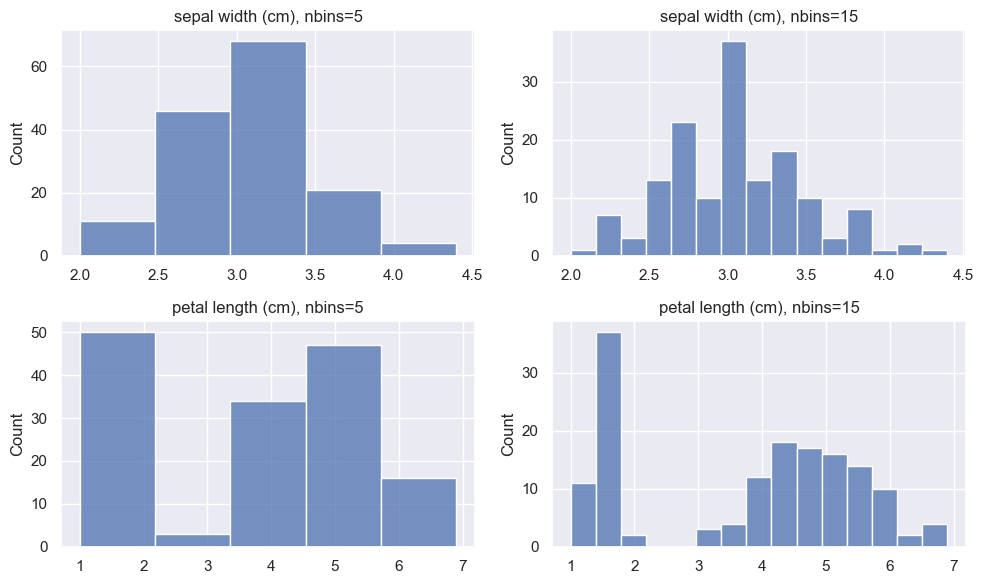

In [6]:
axs = plt.subplots(2, 2, figsize=(10,6))[1]
axs_iter = axs.flat
cases = product(['sepal width (cm)', 'petal length (cm)'], [5, 15])

for feature, nbins in cases:
    ax = next(axs_iter)
    sns.histplot(X, x=feature, bins=nbins, ax=ax)
    ax.set_title(f'{feature}, {nbins=}')
    ax.set_xlabel(None)
    
plt.tight_layout()
plt.show()

[__altair.BinParams__](https://altair-viz.github.io/user_guide/generated/core/altair.BinParams.html#altair-binparams)

In [ ]:
"""
You can specify maxbins, but there is no way to specify an exact number of bins 
without specifying an explicit extent and step for each dataset (in automated 
binnings, vega-lite prioritizes having sensical bin edges over having an exact 
bin count)

https://stackoverflow.com/questions/60839767/altair-faceted-histogram-independent-scales
"""

In [8]:
iris_url = data.iris.url

base = (
    alt.Chart().mark_bar()
    .properties(width=500, height=250)
    .interactive()
)

chart = alt.vconcat(data=iris_url)

for feature in 'sepalWidth', 'petalLength':
    row = alt.hconcat()
    for maxbins in 5, 15:
        row |= base.encode(
            x=alt.X(
                feature, type='quantitative', 
                bin=alt.Bin(maxbins=maxbins)
            ),
            y='count():Q'
        )
    chart &= row

chart

alt.VConcatChart(...)

В случае всего двух бинов их разделяет точка полуразмаха.

Рассмотрим два часто встречающихся типа гистограмм. 

Первый демонстрирует так называемый __степенной закон, или распределение Парето,
оно же — распределение Ципфа__. Этот тип гистограммы часто встречается 
в социальных системах. Согласно эмпирическим исследованиям такие
показатели, как уровень доходов, размер сообществ, уровень производительности
и им подобные распределены по степенному закону. Получается, что ничтожно
малая часть индивидов или объектов обладают большим богатством/популярностью/производительностью, 
в то время как большая часть индивидов остается почти ни с чем.

[__scipy.stats.pareto__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.pareto.html#scipy-stats-pareto)

In [9]:
pareto_rv = pareto(b=2.62)

(array([82., 11.,  3.,  3.,  1.]),
 array([1.00211575, 1.84752845, 2.69294114, 3.53835383, 4.38376652,
        5.22917922]),
 <BarContainer object of 5 artists>)

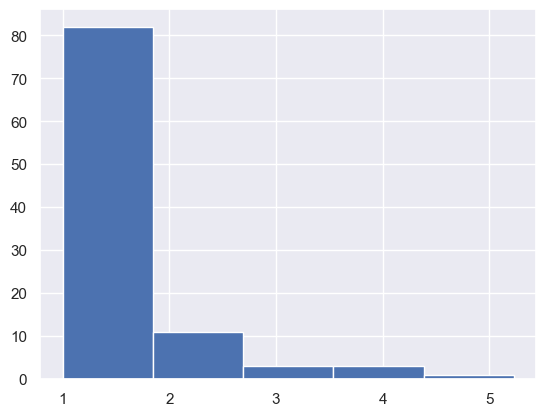

In [10]:
plt.hist(pareto_rv.rvs(size=100, random_state=42), bins=5)

Функция плотности степенного закона (_probability density function_):
$$f(x, b) = \frac{b}{x^{b+1}}, \quad x \ge 1, \; b > 0.$$

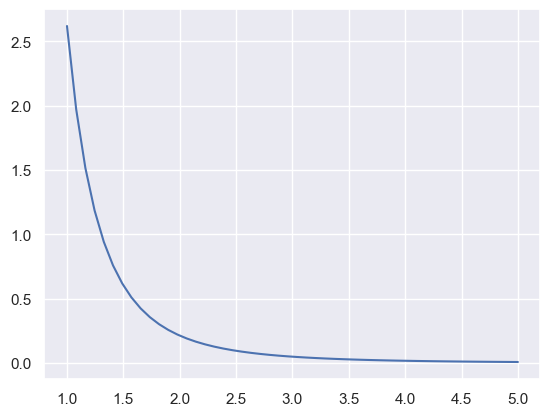

In [11]:
x = np.linspace(1, 5)
plt.plot(x, pareto_rv.pdf(x))

Считается, что этот закон распределения выражает явление, которое называется __эффектом 
Матфея__. Это название связано с притчей о талантах из Евангелия от Матфея:
«Ибо всякому имеющему дастся и приумножится; а у неимеющего отнимется и то,
что имеет» (Мф.25:29). Эффект Матфея проявляется, например, в популярном
«механизме предпочтительного присоединения» в интернете. Согласно этому
механизму вероятность того, что новый пользователь зайдет на определенный
сайт, пропорциональна популярности этого сайта, измеряемой, например, количеством 
«кликов» пользователей на сайт за единицу времени. При этом у более
популярного сайта больше посетителей, что делает его еще более популярным.

Второй тип гистограмм соответствует так называемому __нормальному, или Гауссову,
закону распределения__. Распределение ошибок измерений, и, в целом, величин,
получаемых под действием небольших независимых друг от друга случайных
эффектов, считаются Гауссовыми. Другие распределения, 
порожденные наложением многих малых случайных независимых
эффектов, приближаются к Гауссовому.

[__scipy.stats.norm__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.norm.html#scipy-stats-norm) | [__scipy.stats.gaussian_kde__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.gaussian_kde.html#scipy-stats-gaussian-kde)

<AxesSubplot: ylabel='Count'>

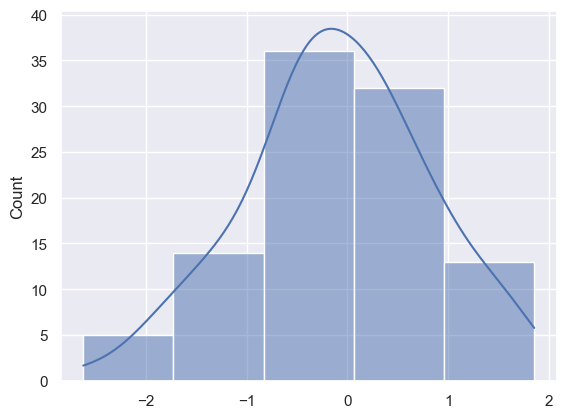

In [12]:
sns.histplot(x=norm.rvs(size=100, random_state=42), bins=5, kde=True)

[__pandas.cut__](https://pandas.pydata.org/docs/reference/api/pandas.cut.html?highlight=cut#pandas-cut)

In [13]:
binning = pd.cut(X['sepal width (cm)'], bins=5).value_counts().sort_index()
binning

(1.998, 2.48]    11
(2.48, 2.96]     46
(2.96, 3.44]     68
(3.44, 3.92]     21
(3.92, 4.4]       4
Name: sepal width (cm), dtype: int64

In [14]:
labels = [f'bin {n}' for n in range(1, 6)]

[__matplotlib.pyplot.pie__](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html#matplotlib-pyplot-pie)

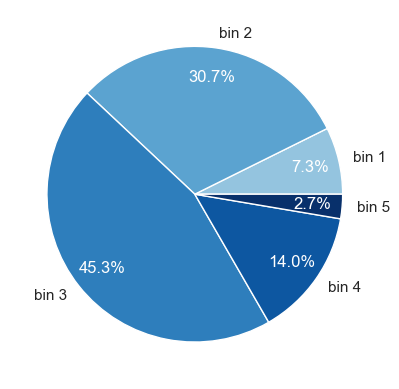

In [15]:
colors = plt.get_cmap('Blues')(np.linspace(0.4, 1, binning.shape[0]))
_, _, autotexts = plt.pie(binning, colors=colors, autopct='%1.1f%%', 
                          pctdistance=0.8, labels=labels)
for autotext in autotexts:
    autotext.set_color('w')

[__matplotlib.pyplot.bar__](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib-pyplot-bar)

<BarContainer object of 5 artists>

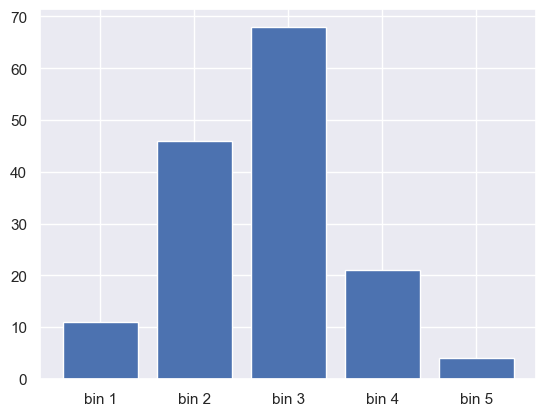

In [16]:
plt.bar(labels, binning)

__Выбор числа бинов определяется пользователем
исходя из характера распределения и цели анализа; надежных теоретических
рекомендаций не существует.__

Гистограмму можно рассматривать как эмпирическое представление теоретической 
так называемой функции плотности распределения.

***
## <a id='toc1_2_'></a>[__Дальнейшая суммаризация: центр и рассеяние__](#toc0_)

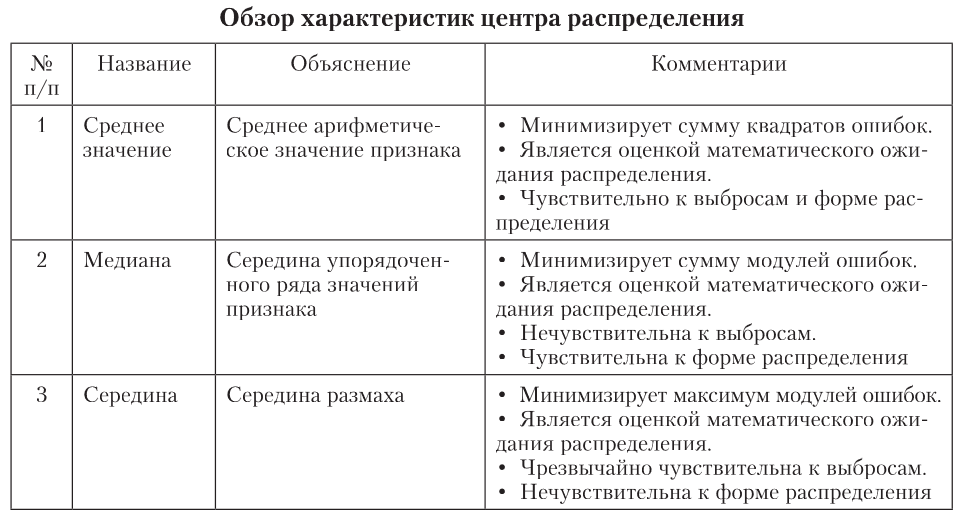

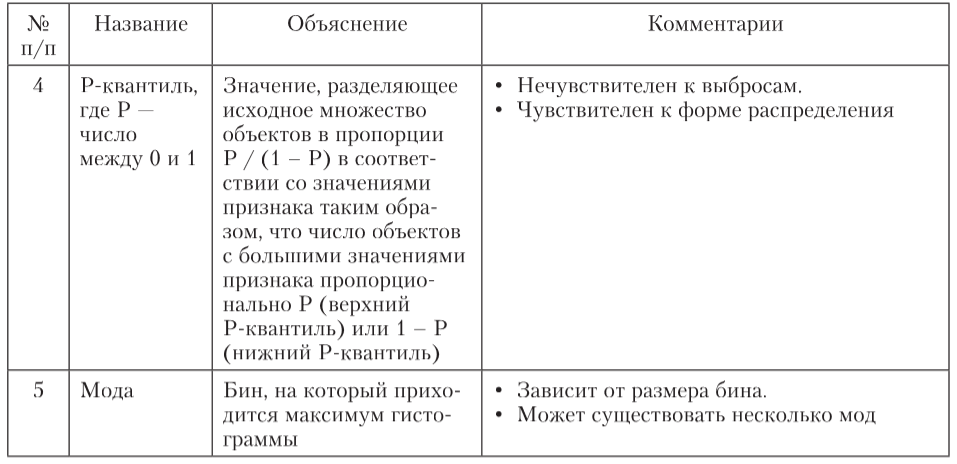

__Середина__ соответствует среднему значению равномерного распределения,
у которого частоты во всех бинах равны. В отличие от среднего значения и медианы, 
середина зависит только от размаха данных, а не от распределения. Очевидно, 
что она чрезвычайно чувствительна к выбросам, т.е. к изменениям максимального 
или минимального значений выборки.

[__numpy.percentile__](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html#numpy-percentile)

Нижний $10\%$-ный квантиль ($16$-ый элемент сортированного __по возрастанию__ массива длиной $150$):

In [17]:
sepal_width_sorted = np.sort(X['sepal width (cm)'])
sepal_width_sorted[15]  # 0-based indexing

2.5

In [18]:
np.percentile(X['sepal width (cm)'], 10, method='higher')

2.5

Верхний $10\%$-ный квантиль ($16$-ый элемент сортированного __по убыванию__ массива длиной $150$):

In [19]:
np.flip(sepal_width_sorted)[15]

3.6

In [20]:
np.percentile(X['sepal width (cm)'], 90, method='lower')

3.6

См. также функцию __`conf_interval_non_pivotal_handmade`__ ниже. Она написана для бутстрэпа, но подходит и здесь.

__Фондовый коэффициент__ характеризует уровень неравенства в распределении значений
признака. Он определяется как отношение среднего самых больших $10\%$ значений и среднего 
самых малых $10\%$ значений.

[__scipy.stats.mstats.trimtail__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.mstats.trimtail.html#scipy-stats-mstats-trimtail)

Замаскировать левые $90\%$ означает оставить правые (наибольшие) $10\%$ и наоборот:

In [21]:
def fcoeff(feature):
    means = [trimtail(feature, 0.9, tail=tail).mean() 
             for tail in ('left', 'right')]
    return np.divide(*means)

In [22]:
fcoeff(X['sepal width (cm)'])

1.6685714285714284

Меры разброса используются для того, чтобы оценить степень ошибочности
соответствующей характеристики центральности. __Стандартное отклонение__ —
это квадратный корень из средней квадратичной ошибки среднего значения.
Популярность этой меры связана с принципом наименьших квадратов, который
в настоящее время превалирует в анализе данных. Использование принципа
наименьших квадратов может быть объяснено хорошими свойствами решений,
которые он дает, с точки зрения анализа данных, и свойствами нормального распределения, 
с точки зрения теории вероятности.

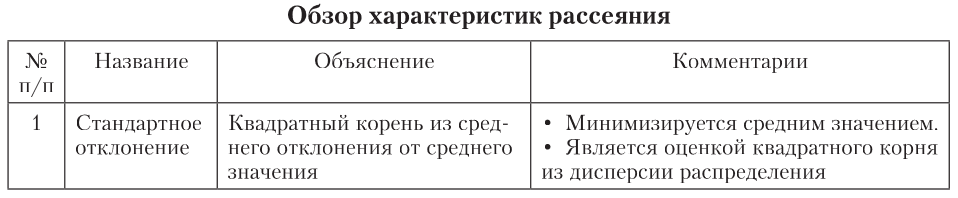

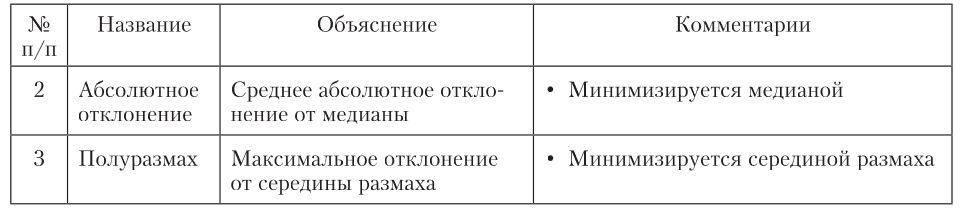

__Абсолютное отклонение__ выражает среднее абсолютное отклонение от медианы.
Как правило, его находят относительно среднего значения, поскольку именно
среднее значение чаще всего берется в качестве центральной характеристики.
Однако среднее абсолютное отклонение лучше соответствует медиане, так как
именно медиана минимизирует его.

__Полуразмах__ выражает максимально возможное отклонение значений от середины 
интервала, поэтому имеет смысл использовать середину интервала и полуразмах 
вместе, как это делают исследователи, изучающие методы построения
классификационных правил.

__В приведенных выше таблицах каждая из характеристик центра минимизирует соответствующую ей меру разброса.__

Существует два принципиально разных взгляда на методы суммаризации
и коррелирования данных. Согласно одному взгляду, наиболее четко выраженному 
в классической математической статистике, __данные порождены неким вероятностным 
механизмом, поэтому их используют для восстановления механизма
или хотя бы некоторых его свойств__. С точки зрения подхода анализа данных
вероятностный механизм не существует или не интересен, а главная задача — это
поиск закономерностей в самих данных как они есть.

Пусть дано множество наблюденных значений признака $X = \{x_1,x_2,\ldots,x_n\}$. Задача —
представить это множество в «сжатом» виде некой центральной точкой $a$. Эта
центральная точка $a$ должна минимизировать среднее индекса расстояния от нее
до всех наблюденных значений:

$$D(X,a) = \frac{1}{N} \sum_{i=1}^N d(x_i,a) \qquad (1)$$

В зависимости от того, как определен индекс расстояния $d(x_i,a)$, оптимальными 
могут быть разные значения $a$. Например, естественно определить 
$$d(x_i,a) = |x_i - a|^p$$
для некоторого вещественного положительного $p$ (__правило Минковского__). К сожалению, нет единого простого метода минимизации $(1)$ для произвольного $p$. Впрочем, для трех значений $p = 1,2,\infty$ можно
указать простые правила вычисления оптимального $a$.

Рассмотрим сначала __принцип наименьших квадратов__, соответствующий $p=2$.
Согласно этому принципу индекс расстояния — это квадрат разности, $d(x,a) = |x - a|^2$. Тогда минимум среднего расстояния $(1)$ достигается в точке $a$, равной
__среднему арифметическому__ значению $c$. Это доказывается приравниванием нулю
производной от выражения $(1)$ при квадратах разностей, подставленных вместо
$d(x_i,a)$. Среднее арифметическое значение определяется выражением

$$c = \frac{1}{N} \sum_{i=1}^N x_i,$$

Следовательно, среднее расстояние $D(X,c)$ $(1)$ в этом случае не что иное, как

$$s^2 = \frac{1}{N} \sum_{i=1}^N (x_i - c)^2.$$

Эта величина часто называется __дисперсией среднего значения__.

Если определить индекс расстояния более традиционным способом просто
как величину отклонения $d(x,a) = |x - a|$, т.е. $p=1$ в формуле $(1)$, то нетрудно
доказать, индукцией по $N$, что оптимальное значение $a$ (центр) при минимизации
$(1)$ — это __медиана__, $m$, а $D(X,a)$ — в этом случае — среднее абсолютное отклонение 
от медианы $ms$:

$$ms = \frac{1}{N} \sum_{i=1}^N |x_i - m|.$$

На самом деле, медиана — единственный оптимум только при нечетном $N$.
Если же $N$ четное, то оптимальной будет любая величина между двумя числами,
$x_{N/2}$ и $x_{N/2 + 1}$, находящимися в середине упорядоченного ряда элементов $X$, включая 
медиану.

Если расстояние $D(X,a)$ в формуле $(1)$ определено не как среднее, а как максимум 
из расстояний,

$$D(X,a) = \max \{d(x_1,a), d(x_2,a), \ldots, d(x_N,a)\},$$

то минимум $(1)$ достигается на __середине размаха__ $mr$. Вместе с тем само правило взятия максимума
величин $d(x_i,a)$ может рассматриваться как предельный случай минимизации
суммы $(1)$ по правилу Минковского при $p \Rightarrow \infty$.

Задача минимизации среднего индекса расстояния, особенно в форме Минковского, 
может быть представлена в рамках __подхода восстановления данных__,
который позволяет развить для аппроксимационной задачи минимизации $(1)$
некоторое подобие теории. Согласно этому подходу любой метод анализа данных 
перекодирует данные к более простому, в какой-то мере «идеальному», виду.
В частности, __в задачах вычисления центральной величины, все наблюденные значения 
рассматриваются как «зашумленные» реализации некого неизвестного значения__ 
$a$, так что имеют место равенства

$$x_i = a + \varepsilon_i, \quad i \in \{1,2,\ldots,N\}, \qquad (2)$$

где $\varepsilon$ — __аддитивные остатки, которые необходимо минимизировать, 
чтобы обеспечить наилучшее качество восстановления данных в случае их
утери — замену каждого значением__ $a$. Чтобы не связываться с совершенно неясной 
проблематикой минимизации всех остатков одновременно, используется какой-либо интегральный критерий. Существует достаточно общее семейство таких критериев — критерий Минковского, математически называемый также нормой $L_p$. __Норма Минковского__ для многомерного набора остатков определяется как

$$L_p = \biggl(|\varepsilon_1|^p + |\varepsilon_2|^p + \ldots + |\varepsilon_N|^p\biggr)^{1/p},$$

где $p$ - некоторое положительное число.

При разных значениях $p$ задача минимизации $L_p$, или, эквивалентно, ее $p$-ой степени 
$L_p^p$, будет давать разные решения. Самые часто используемые значения
$p=1,2,\infty$ как раз и дают вышеупомянутые критерии:

1. __Принцип наименьших квадратов__: минимизировать 
$$L^2_2 = \varepsilon_1^2 + \varepsilon_2^2 + \ldots + \varepsilon_N^2, \quad p=2.$$

Минимизация $L^2_2$ по неизвестному $a$ эквивалентна задаче __минимизации среднего 
квадрата отклонений__ $\varepsilon_i = x_i - a$. Оптимальное $a$ в этой задаче — __среднее значение__.

2. __Принцип наименьших модулей__: минимизировать
$$L_1 = |\varepsilon_1| + |\varepsilon_2| + \ldots + |\varepsilon_N|, \quad p=1.$$

Минимизация $L_1$ по неизвестному $a$ эквивалентна задаче __минимизации среднего 
абсолютного отклонения__. Оптимальное значение $a$ в этой задаче — __медиана__.

3. __Принцип наименьшего максимума (Чебышёва)__: минимизировать
$$L_{\infty} = \max \bigl(|\varepsilon_1|, |\varepsilon_2|, \ldots, |\varepsilon_N|\bigr).$$

Минимизация $L_{\infty}$ по неизвестному $a$ эквивалентна задаче __минимизации максимального 
отклонения__. Оптимальное значение $a$ в этой задаче — __середина размаха__.

Может показаться, что критерий Минковского $L_p^p$ для модели $(2)$ является
всего лишь тривиальной переформулировкой критерия минимизации расстояния
$(1)$. Как говорится, старое вино в новой упаковке. Но это не так. __Дело в том, что
уравнение $(2)$ позволяет не только оценить расстояние, но и разложить разброс
данных на «объясненную» и «необъясненную» составляющие.__

Особенно просто это можно сделать для принципа наименьших квадратов.
Величина критерия в точке $a$, равной среднему значению $c$, равна

$$L_2^2 = (x_1 - c)^2 + (x_2 - c)^2 + \ldots + (x_N - c)^2.$$

Раскроем скобки в этом выражении, приведем подобные 
и получим, что 

$$L_2^2 = \overbrace{x_1^2 + x_2^2 + \ldots + x_N^2}^{\Large T(X)} - 2c\,\underbrace{(x_1 + x_2 + \ldots + x_N)}_{\Large Nc} + Nc^2 = T(X) - Nc^2,$$

где $T(X)$ — __квадратичный разброс данных__, который определяется как сумма квадратов наблюденных значений.

Таким образом, квадратичный разброс данных согласно модели $(2)$ равен

$$\Large T(X) = Nc^2 + L_2^2, \qquad (3),$$

__т.е. состоит из двух частей: первая, $Nc^2$, характеризует ту часть разброса, которая
объясняется моделью $(2)$, а вторая — ту, которая остается необъясненной,__ $L_2^2$.

Поскольку разброс данных — константа, минимизация $L_2^2$ эквивалентна максимизации 
$Nc^2$. __Разложение разброса данных на две составляющие позволяет оценить 
адекватность модели $(2)$ не только с помощью дисперсии, усредненного
квадратичного критерия, но и с помощью относительной величины объясненной
части:__

$$\Large \frac{L_2^2}{T(X)}.$$

Величину $c$ назовем $p$-__центр Минковского__, если она минимизирует 
среднее расстояние Минковского $(1)$ с показателем степени $p$.

***
### <a id='toc1_2_1_'></a>[__Вычисление центра по критерию Минковского__](#toc0_)

Для признака ширина чашелистика из данных об ирисах вычислить центр Минковского при $p = 0.5, 1, 2, 3, 4, 5$.

[__scipy.optimize.minimize_scalar__](https://scipy.github.io/devdocs/reference/generated/scipy.optimize.minimize_scalar.html#scipy-optimize-minimize-scalar)

In [23]:
pnorms = 0.5, 1, 2, 3, 4, 5
a = np.linspace(2.5, 3.5)

In [24]:
def L(a, p):
    return sum(abs(X['sepal width (cm)'][i] - a)**p for i in range(X.shape[0]))

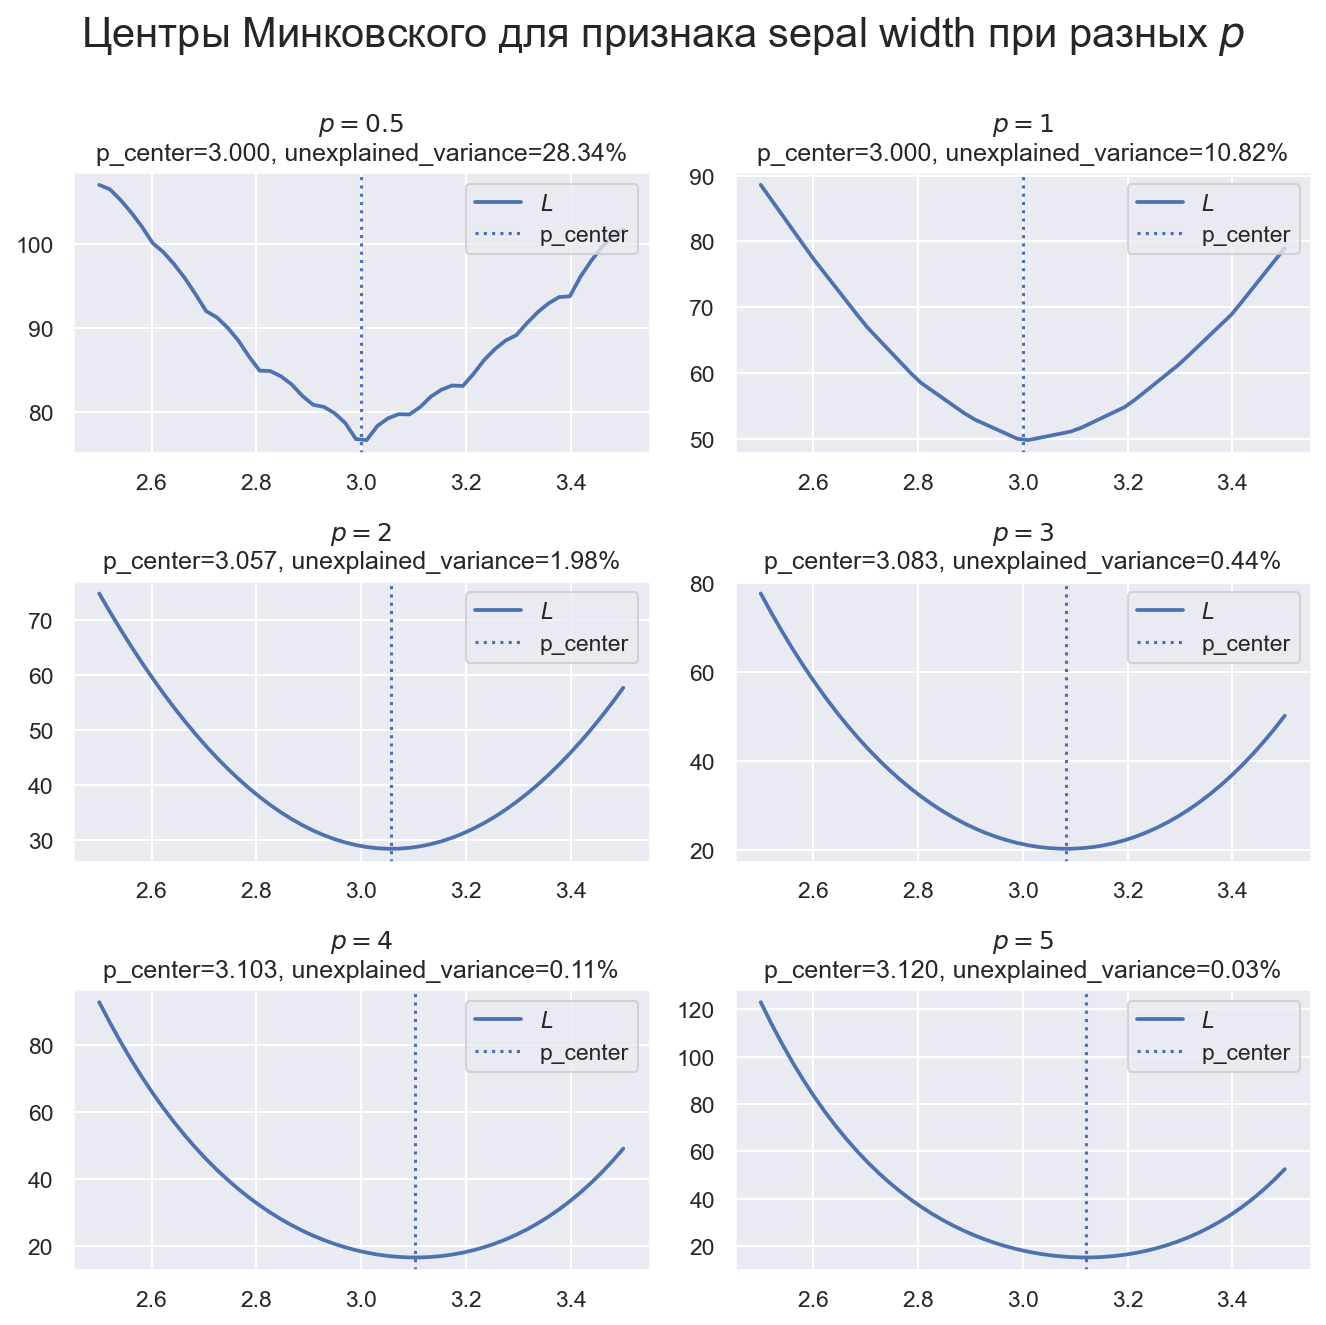

In [25]:
axs = plt.subplots(3, 2, figsize=(9,9), dpi=150)[1]
axs_iter = axs.flat

for p in pnorms:
    L = partial(L, p=p)
    res = minimize_scalar(L)
    p_center = res.x  # optimal a
    T = np.sum(X['sepal width (cm)']**p)
    unexplained_variance = res.fun / T * 100
    
    ax = next(axs_iter)
    ax.plot(a, L(a), lw=1.8, label='$L$')
    ax.axvline(p_center, ls=':', label='p_center')
    ax.legend(loc='upper right')
    ax.set_title(f'${p=}$\n{p_center=:.3f}, {unexplained_variance=:.2f}%')
    
suptitle = 'Центры Минковского для признака sepal width при разных $р$'
plt.suptitle(suptitle, fontsize=20)
plt.tight_layout(rect=(0, 0, 1, 0.98))
plt.show()

In [26]:
sw = data.iris().sepalWidth

In [27]:
def a_grid(*, half_range, hd):
    factor = (10, 100)[hd]
    num = 2 * factor * half_range + 1
    return np.linspace(-half_range, half_range, num)

In [28]:
def p_vec(a, p):
    return [p] * a.size

In [29]:
def L(a, p):
    return sum(abs(sw[i] - a)**p for i in range(sw.size))

In [30]:
def altair_plot_lossfunc(pnorms, *, half_range=100, hd=False):
    a = a_grid(half_range=half_range, hd=hd)
    data = np.r_[*[np.c_[a, p_vec(a, p), L(a, p)] for p in pnorms]]
    df = pd.DataFrame(data, columns=['a', 'p', 'L'])
    
    alt.data_transformers.disable_max_rows()

    chart = (
        alt.Chart(df).mark_line()
        .encode(x='a', y='L', color='p:N')
        .properties(width=500, height=500)
        .interactive()
    )

    return chart

In [31]:
altair_plot_lossfunc(pnorms=[0.5, 1], hd=True)

alt.Chart(...)

In [32]:
altair_plot_lossfunc(pnorms=[2, 3, 4, 5])

alt.Chart(...)

***
## <a id='toc1_3_'></a>[__Бинарные и категоризованные признаки. Индекс Джини, энтропия__](#toc0_)

In [33]:
cyber_attacks = pd.read_csv('cyber_attacks.csv')
cyber_attacks.head()

,Pr,BySD,SH,SS,SE,RE,A
0,TCP,62344,16,16,0.00,0.94,ap
1,TCP,60884,17,17,0.06,0.88,ap
2,TCP,59424,18,18,0.06,0.89,ap
3,TCP,59424,19,19,0.05,0.89,ap
4,TCP,59424,20,20,0.05,0.90,ap


In [34]:
cyber_attacks.shape

(100, 7)

Атака __apache2__ нацелена на популярный веб-сервер открытого пользоваиия, Apache HTTP Server, заставляя его посылать клиенту огромное количество «пустых» запросов
и переполняя буферные каналы. Атака __smurf__ посылает фальшивые ответные послания,
«пинги», по различным адресам, заставляя соответствующие компьютеры отвечать «пингами» же по обратным адресам. Если главный адрес «подделан» нарушителем, возникает
шквал «пингов», направляемых какому-либо серверу из группы компьютеров сети, переполняя 
его входные каналы. Такая атака может начинаться с «разведки», отыскивающей 
проблемы в сети. Популярный софтвер для проведения разведки называется __SAINT__ (_Security Administrator's Integrated Network Tool_).

__`cyber_attacks`__ — случайная выборка из данных, синтезированных в одной
из лабораторий Массачусетского технологического института (Бостон, США). Признаки 
характеризуют пакет и его источник.

* Pr — тип протокола, в данном случае один из трех: _TCP, ICMP, UDP_ (номинальный признак).
* BySD — число байтов в пакете.
* SH — количество соединений источника за последние две секунды.
* SS — число соединений с тем же сервером за последние две секунды.
* SE — процент ошибочных соединений.
* RE — процент соединений с отказом обслуживания.
* A — тип атаки (_ap_ — apache2, _sa_ — SAINT, _sm_ — smurf, _no_ — отсутствие атаки).

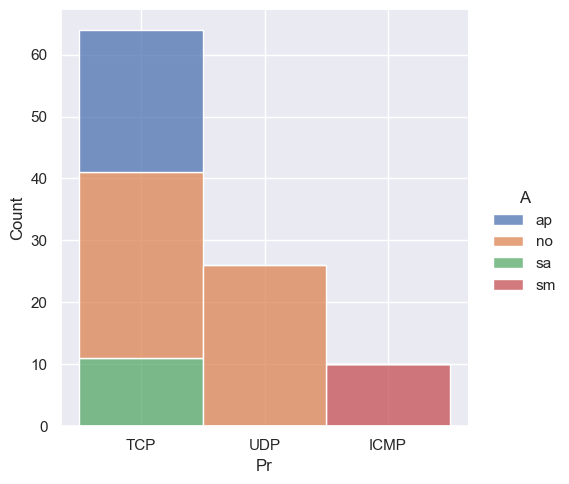

In [35]:
sns.displot(cyber_attacks, x='Pr', hue='A', multiple='stack')

Качественный признак, например, тип протокола __`Pr`__ разбивает множество объектов так, что каждый объект попадает в одну и только в одну категорию. Такие признаки называются __номинальными__.

Рассмотрим номинальный признак с $L$ категориями $l \in \{1,2,\ldots,L\}$. Его распределение 
характеризуется количеством объектов $N_1,N_2,\ldots,N_L$, которые попадают 
в каждую из категорий. Сумма численностей категорий равна общему числу объектов: $N_1 + N_2 + \ldots + N_L = N$. Относительные частоты, определяемые как $p_l = N_l / N, \; l \in \{1,2,\ldots,L\}$, в сумме дают единицу. Это свойство вытекает из альтернативного и всеобъемлющего характера категорий номинального
признака — каждый объект покрывается какой-либо категорией, причем ни один объект не может принадлежать двум категориям или более.

Поскольку категории номинального признака не упорядочены, их лучше визуализировать 
с помощью столбчатых и круговых диаграмм, а не гистограмм.

Характеристики центра, за исключением моды, не имеют смысла для распределений 
качественных признаков. Однако рассеяние, или разнообразие, распределения 
$(p_1,p_2,\ldots,p_L)$ измеряют. Две популярные меры рассеяния: __индекс Джини__,
или __качественная дисперсия__, и __энтропия__.

__Индекс Джини — это средняя ошибка правила пропорционального предсказания (средняя ошибка пропорционального классификатора)__. Такое предсказание осуществляется в ситуации, 
когда объекты, у которых неизвестны значения некоторого качественного
признака, появляются случайно и независимо один за другим. Пропорциональный 
классификатор будет случайным образом присваивать объектам категории
признака в соответствии с вероятностями категорий. Средняя ошибка, т.е. вероятность того, что объекту категории, встречающейся с частотой $p$, будет приписана
другая категория, равна $p(1 - p)$.

Иными словами, принцип действия пропорционального классификатора определяется для объектов,
о которых ничего не известно, кроме распределения категорий $(p_1,p_2,\ldots,p_L)$. Этот классификатор приписывает объектам категорию $l$ с вероятностью $p_l$.

Суммарная средняя ошибка:

$$G = \sum_{l=1}^L p_l (1 - p_l) = 1 - \sum_{l=1}^L p_l^2.$$

__Энтропия усредняет количество информации отдельных категорий__. Информация 
о категории $l$ равна $\log (1/p_l) = -\log p_l$ для любого $l$. Энтропия вычисляется по формуле:

$$H = - \sum_{l=1}^L p_l \log p_l.$$

Понятие «энтропия» было введено для измерения количества информации
в сигналах, передаваемых по каналам связи. Редкие сигналы несут больше информации, 
чем частые. Кроме того, количество информации в независимых сигналах 
можно суммировать, для того чтобы оценить всю переданную информацию.
Эти два условия приводят к необходимости использования логарифма величины
$1/p$, т.е. $-\log p$, в качестве меры количества информации в сигнале, вероятность
которого равна $p$. Логарифм берется по основанию $2$, поскольку все цифровые
устройства используют двоичную систему счисления. __Энтропия определяется как
среднее количество информации, приходящееся на одну категорию качественного 
признака, рассматриваемую как сигнал__. За единицу измерения количества
информации принят один бит — энтропия равномерно распределенного бинарного 
признака, т.е. двоичного разряда с равновероятными значениями: $\log_2 2 = 1$. Иными
словами, бит — это количество информации в ответе на вопрос, допускающий
только два ответа, при условии, что никакого знания о возможном ответе не было.
Максимум энтропии для признака с $m$ категориями, $H = \log m$, достигается при
равномерном распределении. Максимум индекса Джини, $(m-1)/m$, также достигается на равномерном распределении.

См. также [__ml_trees.ipynb__](https://github.com/EvgenyMeredelin/machine-learning-notes-and-codes/blob/main/ml_trees/ml_trees.ipynb).

Найдем распределение, энтропию и индекс Джини для признака тип протокола __`Pr`__ датасета __`cyber_attacks`__.

In [36]:
counts = np.unique(cyber_attacks.Pr, return_counts=True)[1]
p = counts / np.sum(counts)
p  # распределение относительных частот

array([0.1 , 0.64, 0.26])

In [37]:
def gini_index(p):
    return 1 - np.sum(np.square(p))

In [38]:
g = gini_index(p)
g

0.5127999999999999

__Относительный индекс Джини__ - отношение индекса Д. к максимуму индекса Д. при данном количестве категорий (здесь $m=3$): 

In [39]:
g / ((3 - 1) / 3)

0.7691999999999999

In [40]:
h = entropy(p, base=2)
h

1.2495490535693046

В [__scipy.stats.entropy__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.entropy.html#scipy-stats-entropy) допустимо использовать абсолютные частоты - нормировка предусмотрена.

In [41]:
def entropy_handmade(p):
    return -np.sum(p * np.log2(p))

In [42]:
entropy_handmade(p)

1.2495490535693046

In [43]:
h / np.log2(3)  # сравни с относительным индексом Джини выше

0.7883776764439292

***
Отдельный класс номинальных признаков — __бинарные признаки__. У бинарного
признака только две категории. Такие признаки могут появляться сами по себе,
как атрибуты, которые могут присутствовать у объекта, а могут и отсутствовать. 
Но часто они формируются в связи с категориями качественного признака.
Например, категория UDP типа протокола может быть преобразована в бинарный признак в форме вопроса «Правда ли, что атака случилась при использовании протокола UDP?». На этот вопрос может быть
два ответа: «да» или «нет».

__Бинарные признаки совмещают свойства качественных и количественных признаков__. 
Принято считать, что основное различие между качественными и количественными 
типами шкал заключается в множествах допустимых преобразований. 
__Допустимое числовое преобразование изменяет значения признака таким
образом, что отношения между объектами по признаку сохраняются__. Например,
рост человека в сантиметрах может быть пересчитан в миллиметрах, а температура, измеренная в градусах Фаренгейта, может быть преобразована в температуру в градусах Цельсия. 
Такое преобразование не изменяет отношения между различными областями, 
где температура была измерена в градусах Фаренгейта. Если в качестве новых температур выбрать произвольные значения, новое множество измерений будет представлять совершенно другую
информацию. Этим определяется принципиальное различие между количественными 
и номинальными признаками. Значения номинальных признаков можно
сравнивать только на предмет совпадения-несовпадения категорий, так что
допустимы всевозможные взаимно-однозначные преобразования их значений.
У количественных признаков можно изменять масштаб и сдвигать точку отсчета
(начало шкалы), т.е. допустимы только так называемые _аффинные преобразования_. 
Такие преобразования переводят значения $x$ в значения $y$ с помощью двух
числовых параметров, $ax + b \Rightarrow y$, где $a$ характеризует изменение масштаба, а $b$ —
сдвиг точки отсчета шкалы. Это различие между типами шкал, однако, не работает 
для бинарных признаков. Дело в том, что для бинарных признаков любое их
числовое преобразование определяется всего двумя константами — теми, которые
замещают $0$ и $1$ соответственно. Эти константы могут быть связаны со сдвигом
точки отсчета и изменением масштаба. Точнее, чтобы преобразовать значения
бинарного признака: $0$ в $\alpha$, а $1$ в $\beta$, нужно всего два параметра: сдвиг $b$ определяется величиной $\alpha$, а масштаб $a$ — разностью $\beta - \alpha$. Это означает, что бинарный признак — одновременно и номинальный, и количественный.

Значения любого бинарного признака могут быть представлены двумя числами: 
$1$ для «да», $0$ для «нет». Иногда так закодированные категории называют
__дамми (dummy)__, или __фиктивными переменными__.

***
## <a id='toc1_4_'></a>[__Доверительный интервал бутстрэп-методом__](#toc0_)

In [44]:
columns = 'normal', 'bimodal', 'pareto'
df = pd.read_csv('short-dat.csv', header=None, names=columns)
df.head()

,normal,bimodal,pareto
0,8,20,1512
1,12,21,50
2,11,23,48
3,10,21,206
4,9,9,12


In [45]:
df.shape

(50, 3)

Первый столбец — это выборка из Гауссова распределения $N(10,2)$. Второй
столбец — выборка из двумодального распределения, а третий — из степенного
распределения. Среднее значение степенного распределения 
не имеет особого смысла, поскольку оно более чем в $3$ раза меньше стандартного 
отклонения:

In [46]:
df.mean()

normal      10.24
bimodal     16.86
pareto     289.72
dtype: float64

In [47]:
df.std()

normal       1.767738
bimodal      4.961114
pareto     923.826869
dtype: float64

In [48]:
df.std() / np.sqrt(df.shape[0])

normal       0.249996
bimodal      0.701607
pareto     130.648849
dtype: float64

Достаточно ли $50$ наблюдений для того, чтобы представить всю генеральную
совокупность двумя числами? Для решения этой проблемы в математической
статистике выработаны методы, основанные на предположении, что все наблюдения 
выбраны случайным и независимым образом из одного, возможно не известного, 
но стационарного, распределения. Тогда в достаточно четко определенных
ситуациях для таких показателей, как среднее значение, может быть построено
свое теоретическое распределение и, следовательно, некоторые доверительные
границы для значений показателя. Как правило, доверительные границы определяют 
по интервалу, в который попадает $95\%$ наблюдений из генеральной совокупности, 
ведь ее распределение известно. Для первой колонки данных теоретически 
обоснованный доверительный интервал при условии, что настоящие параметры
распределения известны, имеет границы

In [49]:
loc = 10
scale = 2 / np.sqrt(df.shape[0])
norm.interval(0.95, loc=loc, scale=scale)

(9.445638470260128, 10.554361529739872)

Для наблюдаемых данных:

In [50]:
loc = df.normal.mean()
scale = df.normal.std() / np.sqrt(df.shape[0])
norm.interval(0.95, loc=loc, scale=scale)

(9.750017003783292, 10.729982996216709)

In [51]:
# refresh
tuple(loc - norm.ppf((1 + j*0.95) / 2) * scale for j in (1, -1))

(9.750017003783292, 10.729982996216709)

Во многих практических приложениях форма распределения неизвестна,
к тому же оно не обязательно стационарно. В таких случаях ценность теоретических 
доверительных интервалов невелика. Можно ли найти какие-нибудь доверительные границы вычислительным
образом, используя только имеющуюся выборку? Разработано несколько подходов к вычислительной валидации показателей, построенных по выборке. Один из самых популярных таких методов —
это __бутстрэп__. Ниже будут описаны две версии этого метода: __опорный (pivotal)__ и __безопорный (non-pivotal)__.

Бутстрэп основан на некотором количестве, например $1000$, случайных испытаний. 
Каждое испытание состоит из $N$ случайных выборов объектов из выборки
с возвращением, где $N$ — это количество объектов в исходном множестве.
Поскольку проводится выбор с возвращением, некоторые объекты могут быть
выбраны несколько раз, а другие останутся не выбранными ни разу. Нетрудно
убедиться, что в среднем $\frac{e-1}{e} \approx 63.2\%$ всех объектов попадут в выборку
одного испытания. Действительно, при каждом случайном
выборе из множества размером $N$, вероятность не быть выбранным для любого
объекта составляет $1 - \frac{1}{N}$. Поэтому вероятность быть не выбранным при $N$
независимых выборах равна 

$$\left(1 - \frac{1}{N}\right)^N \approx \frac{1}{e} \approx 36.8\%$$
от общего числа объектов.

In [52]:
# первый замечательный предел
n = sym.Symbol('n')
res = sym.limit((1 - 1/n)**n, n, sym.oo)
res

exp(-1)

In [53]:
res.evalf()

0.367879441171442

Метод валидации __с опорой__ основан на предположении, что распределение
значений средних значений бутстрэпа является Гауссовым. Это значит, что имея
оценку среднего, $m_b$, и стандартного отклонения, $s_b$, этого распределения, можно
воспользоваться обычной «теоретической» формулой для нахождения $95\%$-ого
доверительного интервала, $m_b \pm 1.96 s_b$.

__Безопорный метод бутстрэпа__ не использует никаких допущений о характере
распределения средних значений бутстрэпа. Доверительные границы определяются 
непосредственно по полученному распределению средних значений путем
отрезания $2.5\%$-ых нижнего и верхнего квантилей. Это делается так: весь список
средних значений бутстрэпа сортируют в порядке возрастания, после чего отделяют 
нижние и верхние $2.5\%$ значений. Для случая $1000$ испытаний для этого
надо взять соответственно $26$-ю и $975$-ю компоненты отсортированного списка.

Существует теоретическое доказательство того, что в случае, когда исходное
распределение нормально, бутстрэп позволяет получить более узкие значения
стандартного отклонения.

К сожалению, бутстрэп не столь полезен для анализа двух других распределений. 
Он позволяет найти довольно точный доверительный интервал для
среднего значения как по бимодальному распределению, так и по степенному
закону. Однако отыскание математического ожидания обоих этих распределений
на практике не имеет смысла. В первом случае смешиваются две разнородные
группы, во втором — скрывается еще более глубинная неоднородность распределения. 
По-видимому, требуются другие методы, такие как кластерный анализ, для
того чтобы сформировать более однородные множества наблюдений.

Построим оценки $95\%$-ого доверительного интервала, с опорой и без, для распределений из таблицы.

[__scipy.stats.mstats.trimboth__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.mstats.trimboth.html#scipy-stats-mstats-trimboth)

In [54]:
def conf_interval_pivotal(bs_distr, conf_level):
    return norm.interval(conf_level, np.mean(bs_distr), np.std(bs_distr, ddof=1))

In [55]:
def conf_interval_non_pivotal_handmade(bs_distr, conf_level):
    proportiontocut = (100 - conf_level * 100) / 200
    bs_distr_trimmed = trimboth(bs_distr, proportiontocut)
    return bs_distr_trimmed.min(), bs_distr_trimmed.max()

In [56]:
def conf_interval_non_pivotal_scipy(data, statistic, *, n_resamples, conf_level):
    res = bootstrap(np.array(data).reshape(1,-1), statistic,
                    n_resamples=n_resamples, confidence_level=conf_level,
                    method='percentile')
    return res.confidence_interval

In [57]:
def plot_bootstrap(data, statistic, *, bins, n_resamples=9999, conf_level=0.95):
    data_name, bs_distr = '', []
    
    if isinstance(data, pd.Series):
        data_name = data.name
        data = data.values
        
    hasddof = 'ddof' in signature(statistic).parameters
    kwargs = dict(ddof=1) if hasddof else dict()
    
    for _ in range(n_resamples):
        bs_distr.append(statistic(resample(data), **kwargs))
    
    cases = [f'\noriginal sample, ',
             f' bootstrap {statistic.__name__}\n{n_resamples=}, '] 
    
    axs = plt.subplots(1, 2, figsize=(8,4), dpi=120)[1]
    params = zip(range(2), (data, bs_distr), bins, cases)
    for i, sample, n_bins, case in params:
        axs[i].hist(sample, n_bins, alpha=0.66)
        axs[i].set_title(f'{data_name}{case}{n_bins=}')
    plt.tight_layout()
    
    fields = ['std_original_data', 
              f'std_bootstrap_{statistic.__name__}', 
              'conf_interval_pivotal', 
              'conf_interval_non_pivotal_handmade', 
              'conf_interval_non_pivotal_scipy']
    
    BootstrapResult = namedtuple('BootstrapResult', fields)
    
    return BootstrapResult(
        np.std(data, ddof=1) / np.sqrt(len(data)), 
        np.std(bs_distr, ddof=1),
        conf_interval_pivotal(bs_distr, conf_level),
        conf_interval_non_pivotal_handmade(bs_distr, conf_level),
        conf_interval_non_pivotal_scipy(data, statistic, 
                                        n_resamples=n_resamples,
                                        conf_level=conf_level))

BootstrapResult(
    std_original_data=0.24999591833402693,
    std_bootstrap_mean=0.24767833958802113,
    conf_interval_pivotal=(9.754173336052938, 10.725054586739342),
    conf_interval_non_pivotal_handmade=(9.74, 10.72),
    conf_interval_non_pivotal_scipy=ConfidenceInterval(low=9.76, high=10.74),
)



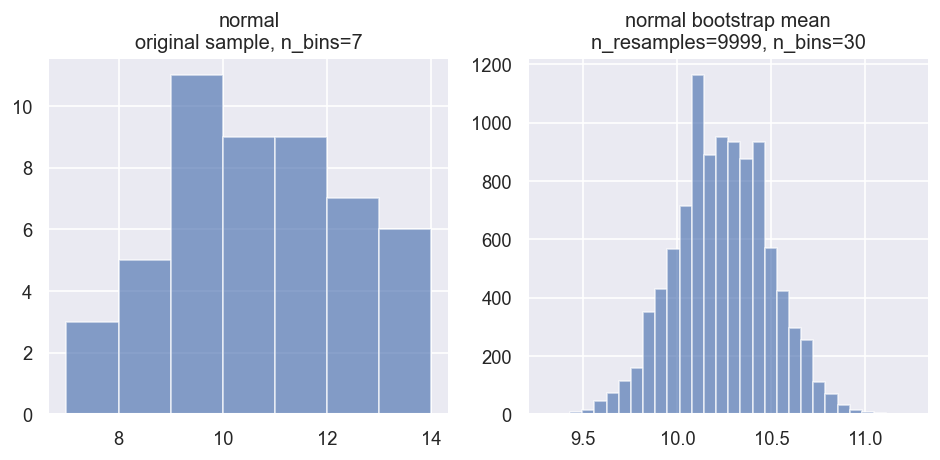

In [58]:
print_black(plot_bootstrap(df.normal, np.mean, bins=(7, 30)))

BootstrapResult(
    std_original_data=0.7016074837289649,
    std_bootstrap_mean=0.6982009962694589,
    conf_interval_pivotal=(15.490391077330274, 18.22728869064652),
    conf_interval_non_pivotal_handmade=(15.46, 18.18),
    conf_interval_non_pivotal_scipy=ConfidenceInterval(low=15.46, high=18.2),
)



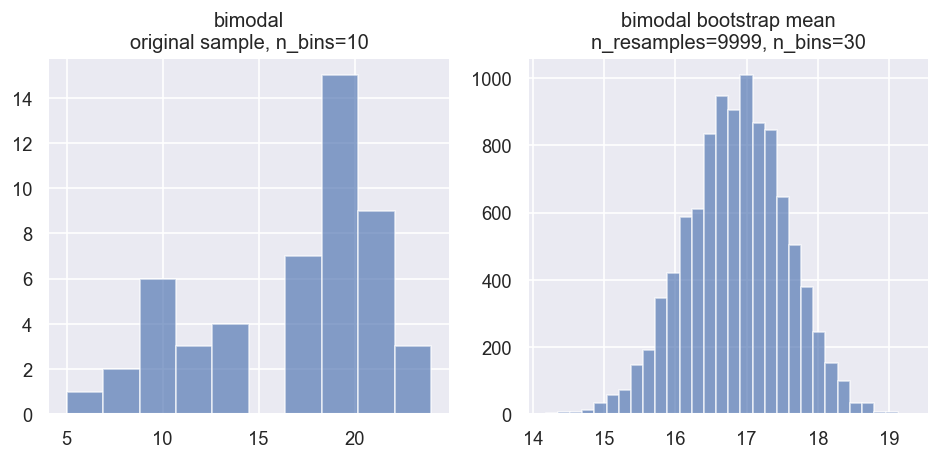

In [59]:
print_black(plot_bootstrap(df.bimodal, np.mean, bins=(10, 30)))

BootstrapResult(
    std_original_data=130.64884869491243,
    std_bootstrap_mean=129.96475611611842,
    conf_interval_pivotal=(36.238963273328295, 545.6914457675759),
    conf_interval_non_pivotal_handmade=(98.76, 590.0),
    conf_interval_non_pivotal_scipy=ConfidenceInterval(low=102.018, high=586.821),
)



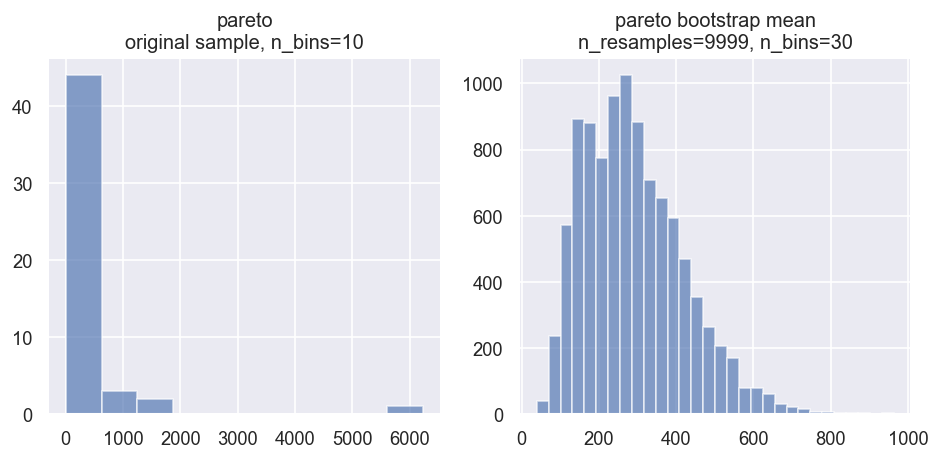

In [60]:
print_black(plot_bootstrap(df.pareto, np.mean, bins=(10, 30)))

***
## <a id='toc1_5_'></a>[__Перекрестная валидация (скользящий контроль)__](#toc0_)

Еще один метод валидации использует идею случайного разбиения данных
на две части, обучающую и тестовую. Результаты, полученные на обучающем
множестве, применяют к тестовому множеству и сравнивают с тем, что известно
для тестового множества. Для того чтобы каждый объект попадал в обучающее
и тестовое множества с одинаковой частотой, пользуются специально разработанным 
__методом перекрестной валидации__, по-русски называемым иногда __скользящим
контролем__.

Так называемая $K$-частная перекрестная валидация организована следующим
образом. Случайным образом разбиваем множество объектов на $K$ частей $Q(k), \, k \in \{1,2,\ldots,K\}$ одинакового размера. По традиции, $K$ выбирают равным $2$, $5$ или $10$.

В цикле по $k$ каждая часть $Q(k)$ используется как тестовое множество, а объединение 
остальных образует обучающее множество. Рассматриваемый метод анализа 
данных применяют к обучающему множеству (стадия обучения), а результат
применяют к тестовой выборке. Средняя оценка по всем тестовым множествам
составляет оценку качества метода по $K$-частной перекрестной валидации.

Случай, когда $K$ равно числу объектов $N$, особенно популярен. Ранее он
назывался __джек-найф__ (__jack-knife__ — складной нож), но сейчас чаще пользуются
названием «выставлять-по-одному» (__leave-one-out__). Это название отражает суть
метода: проводится $N$ обучений анализируемого метода на множествах, полученных 
исключением из $X$ ровно одного объекта.

Применим метод $10$-частной перекрестной проверки к задаче оценки стандартного отклонения вышерассмотренных трех наборов данных. Для начала разобьем множество из $50$ объектов на $10$ непересекающихся классов по пять объектов каждый. Важно, чтобы объекты попадали в классы разбиения
случайным образом. Для каждого класса $Q(k), \, k \in \{1,2,\ldots,K\}$, находим стандартное отклонение на $45$ объектах. Найденные $10$ стандартных отклонений усредняются.

[__sklearn.model_selection.KFold__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn-model-selection-kfold)

In [61]:
def kfold_validation(data, statistic, *, n_splits):
    data = np.array(data)
    kf = KFold(n_splits=n_splits, shuffle=True)    
    
    statistic_distr = []
    name = statistic.__name__
        
    hasddof = 'ddof' in signature(statistic).parameters
    kwargs = dict(ddof=1) if hasddof else dict()
    
    for train_index, _ in kf.split(data):
        statistic_distr.append(statistic(data[train_index], **kwargs))
    
    fields = f'{name}_original_data', f'{name}_kfold'
    KFoldResult = namedtuple('KFoldResult', fields)    
    return KFoldResult(statistic(data, **kwargs), np.mean(statistic_distr))

In [62]:
kfold_validation(df.normal, np.std, n_splits=10)

KFoldResult(std_original_data=1.767738091229488, std_kfold=1.766300698881571)

In [63]:
df.apply(lambda col: kfold_validation(col, np.std, n_splits=10))

,normal,bimodal,pareto
0,1.767738,4.961114,923.826869
1,1.767025,4.960959,905.952178


***
## <a id='toc1_6_'></a>[__Решение заданий по темам главы__](#toc0_)

__Задание__. Рассмотрим признак $x$, изменяющийся в пределах между $1$ и $10$.
Разделим размах $x$ на $9$ бинов (в этом случае длина бина — $1$). Частоты $x$ в бинах
в порядке нумерации равны: 

$$10, 20, 10, 20, 30, 20, 40, 20, 30.$$

Ответьте на вопросы.

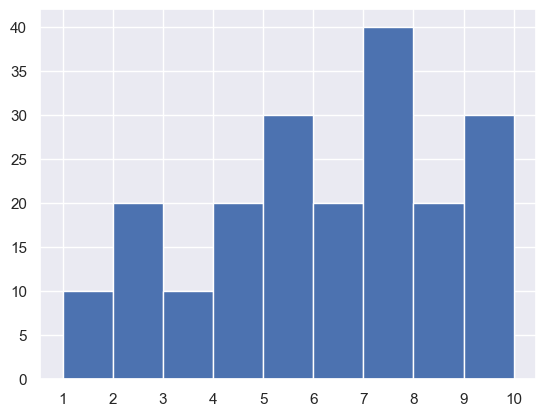

In [64]:
counts = np.array([10, 20, 10, 20, 30, 20, 40, 20, 30])
rng = np.random.default_rng(42)

x = []

for i, count in enumerate(counts, 1):
    x.extend(rng.random(count) + i)  # [0,1) + i
    
plt.hist(x, bins=counts.size, range=(1, 10))
plt.xticks(range(1, 11))
plt.show()

* Сколько всего наблюдений $x$?

In [65]:
counts.sum()

200

* Что можно сказать о медиане $x$?

Медиана лежит между $100$-ым и $101$-ым значением в упорядоченном списке,
т.е. в шестом бине, следовательно, между $6$ и $7$.

In [66]:
central_pair = np.sort(x)[99:101]  # 0-based indexing
central_pair

array([6.44615628, 6.4493615 ])

In [67]:
central_pair.sum() / 2

6.4477588888589095

In [68]:
np.median(x)

6.4477588888589095

* Посчитайте минимальную и максимальную оценки среднего значения $x$.

Минимальная оценка математического ожидания рассчитывается по минимальным 
значениям признака в бинах: 

$$(1 \cdot 10 + 2 \cdot 20 + 3 \cdot 10 + 4 \cdot 20 + 5 \cdot 30 + 6 \cdot 20 + 7 \cdot 40 + 8 \cdot 20 + 9 \cdot 30)\, / \, 200 = 5.7.$$

Максимальная оценка рассчитывается по той же формуле, только значения
признака во всех бинах увеличиваете на $1$. Получаем: $5.7 + 1 = 6.7$.

Пояснение. Матожидание "на минималках" - сумма произведений минимумов в бинах на соответствующие частоты, нормированные общим количеством наблюдений ($200$ можно вынести за скобки). Максимальная оценка рассчитывается по той же логике, но от минимума в бине плюс длина бина, которая в данном случае равна $1$. 

In [69]:
E = lambda mins, delta: (mins + delta) @ counts / counts.sum()

Минимум в бине можно интерпретировать по-разному: как левую границу бина, как минимальное значение признака в нем, т.е. отталкиваясь от конкретных данных. В условии задачи распределение признака не дано, поэтому в решении автора реализован первый сценарий. Имея сгенерированные по заданным частотам случайные данные, реализуем оба сценария.

In [70]:
bins = pd.cut(x, bins=range(1, 11), right=False)
bins.value_counts().sort_index()

[1, 2)     10
[2, 3)     20
[3, 4)     10
[4, 5)     20
[5, 6)     30
[6, 7)     20
[7, 8)     40
[8, 9)     20
[9, 10)    30
dtype: int64

In [71]:
min_series = pd.Series(x).groupby(bins).min()
min_series

[1, 2)     1.094177
[2, 3)     2.043804
[3, 4)     3.129922
[4, 5)     4.007362
[5, 6)     5.022712
[6, 7)     6.087650
[7, 8)     7.021612
[8, 9)     8.037413
[9, 10)    9.044911
dtype: float64

In [72]:
[E(*pair) for pair in product([np.arange(1,10), min_series], [0, 1])]

[5.7, 6.7, 5.743293613619202, 6.743293613619203]

О том, как получается максимальная оценка прибавкой единицы. Увеличение значений признака в бинах на единицу равносильно увеличению числителя на [одну] сумму частот, которая стоит в знаменателе и нормирует числитель. Значит, результат нормировки просто увеличится на $1$.

* Что можно сказать о $20\%$-ых квантилях $x$?

$20\%$ от $200$ равно $40$. Это означает, что $20\%$-ый квантиль с левого края —
это $4$. $20\%$-ый квантиль с правого конца попадает в восьмой бин, следовательно,
лежит между $8$ и $9$.

In [73]:
# срез по (1 - 0.6) / 2 с обоих концов и взятие границ
L, R = conf_interval_non_pivotal_handmade(x, 0.6)
L, R

(4.007362269751005, 8.554852469391484)

In [74]:
np.percentile(x, 20, method='higher')

4.007362269751005

In [75]:
L == min_series.iloc[3]

True

In [76]:
# равносильно higher при шагании справа налево
np.percentile(x, 80, method='lower')

8.554852469391484

[__numpy.digitize__](https://numpy.org/doc/stable/reference/generated/numpy.digitize.html#numpy-digitize)

In [77]:
np.digitize([L, R], range(1, 11))

array([4, 8], dtype=int64)

* Как выглядит распределение $x$ ‚ если число бинов равно $3$? Какова качественная 
дисперсия (индекс Джини) для этого распределения?

Данное распределение для случая трех бинов будет $40, 70, 90$ или, в относительных 
частотах, $0.2, 0.35, 0.45$. Следовательно, индекс Джини равен 

$$1 - \left(0.2^2 + 0.35^2 + 0.45^2\right) = 0.635.$$

array([0.2 , 0.35, 0.45])

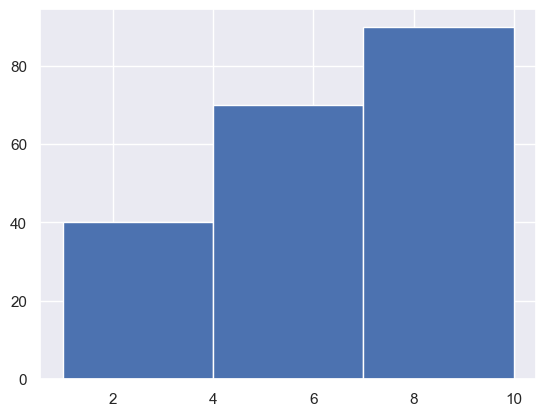

In [78]:
p  = plt.hist(x, bins=3, range=(1, 10))[0] / counts.sum()
p  # относительные частоты

In [79]:
gini_index(p)

0.635

__Задание__. Из $100$ покупателей новогодних подарков 
$50$ потратили по $60$ долл., $20$ потратили по $100$ долл., и $30$ — по $150$ долл. каждый. 
Найдите среднюю, медианную и модальную траты. Подсказка: Как, учитывая то, что покупатели объединены в три группы, сделать вычисления центров более эффективными?

In [80]:
counts = np.array([50, 20, 30])
p = counts / np.sum(counts)
values = np.array([60, 100, 150])
E = p @ values
E

95.0

В данном случае медиана - полусумма $50$-ого и $51$-ого элементов сортированного массива трат: $(60 + 100) / 2 = 80.$

Модальное значение — наиболее вероятное, т.е. $60$.

__Задание__. Рассмотрим два геологических разреза, для одного из которых
имеется семь образцов, а для другого — пять. Содержание определенного минерала 
в образцах разреза $A$ описано вектором

$$a = (7.6, \; 11.1, \; 6.8, \; 9.8, \; 4.9, \; 6.1, \; 15.1),$$

а в разрезе $B$ — 
$$b = (4.7, \; 6.4, \; 4.1, \; 3.7, \; 3.9).$$

Среднее содержание этого минерала в $A$ составляет $8.77$, а в $B$ — $4.56$. Протестируйте гипотезу «содержание минерала в разрезе $A$ больше, чем в разрезе $B$» на $95\%$-ом уровне доверия с использованием бутстрэпа.

__Ответ автора учебника__. Поскольку множества маленькие, число испытаний должно быть
выбрано не слишком большим. При $200$ испытаниях $95\%$-ый доверительный
интервал образован $6$-ым и $195$-ым значениями в списке отсортированных средних
значений бутстрэпа. В нашем случае это интервал $(6.66, 11.09)$ для $A$ и $(3.82,
5.44)$ для $B$. Поскольку все элементы первого интервала больше всех элементов
второго, гипотеза может считаться подтвержденной. Данное решение не совсем
корректно, так как в утверждении «разрез $A$ богаче разреза $B$» есть неточность.
Например, можно считать, что $A$ богаче $B$ на $95\%$-ом уровне доверия, если случайная выборка из $A$ богаче случайной выборки из $B$ в $95\%$ случаев. Тогда
$95\%$-ого интервала не достаточно, поскольку он покрывает только $0.95 \times 0.95 = 90.25\%$ всех возможных пар средних значений бутстрэпа. Посмотрим на минимальные 
и максимальные средние значения бутстрэпа. Размах средних значений
равен $(6.33, 11.94)$ для $A$ и $(3.82, 5.82)$ для $B$. Интервалы не пересекаются, один
лежит строго правее другого, что означает, что гипотеза доказана, даже и при
ограничениях метода.

Не могу согласиться с автором. Во-первых, сразу бросается в глаза, что для $B$ что у размаха, что у доверительного интервала, который лежит внутри размаха, одно и то же значение левой границы - $3.82$. Во-вторых, как показано кодом ниже, можно найти случаи не только пересечения размахов, а они встречаются часто - более чем в $40\%$ случаев, - но и случаи пересечения доверительных интервалов. Впрочем, это, конечно, не меняет вердикта по гипотезе - разрез $A$ действительно богаче разреза $B$ на $95\%$-ом уровне доверия, что показано двумя решениями ниже.

In [81]:
a = np.array([7.6, 11.1, 6.8, 9.8, 4.9, 6.1, 15.1])
b = np.array([4.7, 6.4, 4.1, 3.7, 3.9])

In [82]:
def bootstrap_result(sample):
    return bootstrap(sample.reshape(1,-1), np.mean, n_resamples=200)

Будем делать $200$-семпловые сессии бутстрепа до тех пор, пока не найдется случай, когда левая граница доверительного интервала средних $a$ лежит левее (меньше) правой границы доверительного интервала средних $b$, попутно считая случаи пересечения размахов средних, т.е. когда минимум распределения средних $a$ лежит левее (меньше) максимума распределения средних $b$. Полученную пару распределений средних, пересекающихся доверительными интервалами, используем для проведения теста в первом решении.

In [83]:
n_distr_intersections = n_iters = 0
ci_intersection = False

while not ci_intersection:
    a_res, b_res = [bootstrap_result(x) for x in (a, b)]
    if a_res.confidence_interval.low < b_res.confidence_interval.high:
        ci_intersection = True
        n_distr_intersections += 1
        data = tuple(res.bootstrap_distribution for res in (a_res, b_res))
    elif a_res.bootstrap_distribution.min() < b_res.bootstrap_distribution.max():
        n_distr_intersections += 1
    n_iters += 1

In [84]:
n_distr_intersections, n_iters

(377, 865)

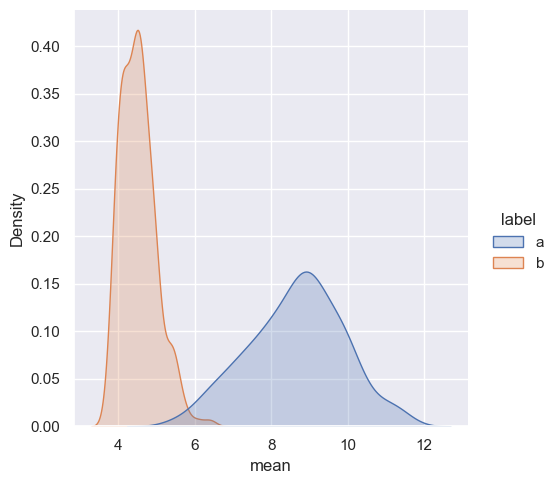

In [85]:
distrs = pd.DataFrame({'label': ['a']*200 + ['b']*200, 'mean': np.r_[*data]})
sns.displot(distrs, x='mean', hue='label', kind='kde', fill=True)

In [86]:
ttest_ind(*data, equal_var=False, alternative='greater')

Ttest_indResult(statistic=44.316900630219166, pvalue=4.6790408244083164e-122)

Второе решение. Работаем с исходными выборками. Тест на нормальность, F-тест на равенство дисперсий, двухвыборочный односторонний t-тест. См. [__stats_tests.ipynb__](https://github.com/EvgenyMeredelin/math-for-data-science/blob/main/stats_tests.ipynb).

In [87]:
shapiro(a)

ShapiroResult(statistic=0.930716872215271, pvalue=0.5570127367973328)

In [88]:
shapiro(b)

ShapiroResult(statistic=0.8244177103042603, pvalue=0.1262395679950714)

In [89]:
F = a.var(ddof=1) / b.var(ddof=1)
dfn, dfd = a.size - 1, b.size - 1
p_value = fdist.sf(F, dfn, dfd)
equal_var = p_value >= 0.05
equal_var

False

In [90]:
ttest_ind(a, b, equal_var=equal_var, alternative='greater')

Ttest_indResult(statistic=2.9783288646777155, pvalue=0.009442427025256236)

__Задание__. Рассмотрите гистограммы признаков из данных об ирисах и покажите, что два признака бимодальны.

In [91]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


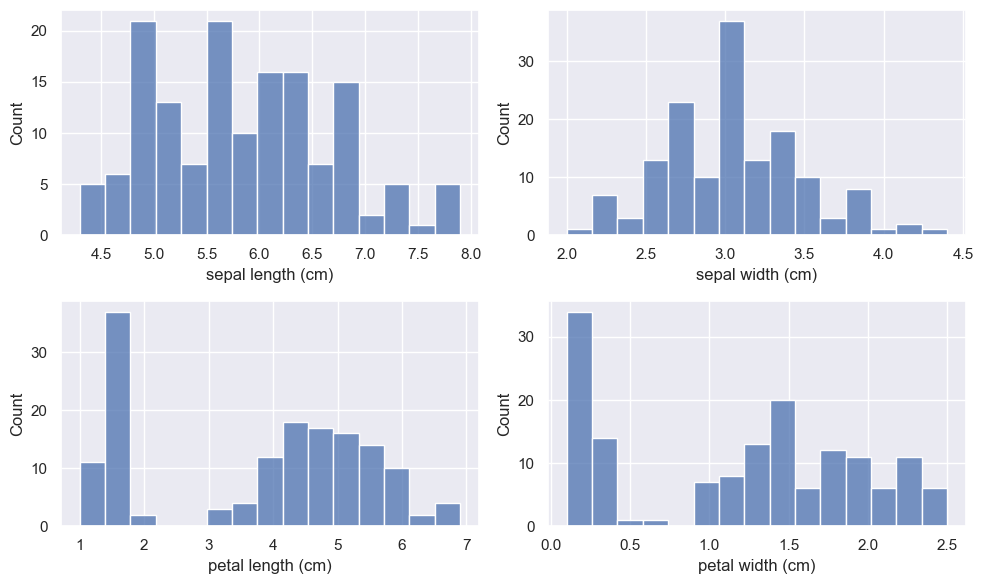

In [92]:
axs = plt.subplots(2, 2, figsize=(10,6))[1]
axs_iter = axs.flat

for feature in X:
    ax = next(axs_iter)
    sns.histplot(X, x=feature, bins=15, ax=ax)
    
plt.tight_layout()
plt.show()

__Задание__. Студент решил провести вычислительный эксперимент. Он случайным 
образом сгенерировал относительные частоты категорий для качественного 
признака с тремя категориями. Для этого он сгенерировал три случайных
числа в интервале $(0, 1)$ и затем нормировал их суммой. Правильны ли действия студента?

Ответ. Нет, поскольку создается сдвиг в сторону равных частот.

$a/(a+b)$ тем ближе к $1/2$, чем ближе $b$ к $a$, т.е. близость значений друг к другу влияет на распределение, искажает его, чего, конечно, быть не должно, потому что желаемое распределение - равномерное.

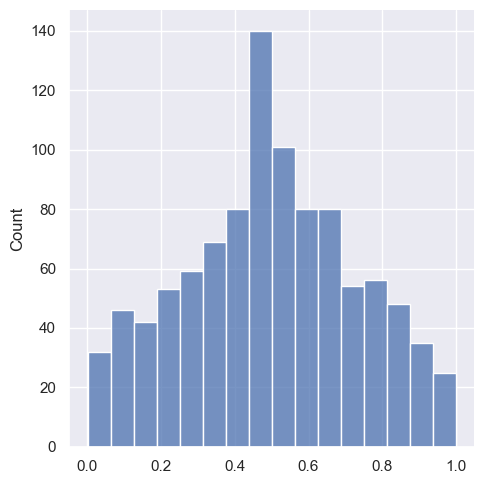

In [93]:
biased = [((pair := rng.random(2)) / np.sum(pair))[0] for _ in range(1000)]
sns.displot(x=biased)

Правильным был бы, например, следующий метод генерации случайной тройки
чисел. Сначала генерируем два случайных числа и сортируем их по возрастанию.
Добавим $0$ и $1$ к выборке: 

$$r_0 = 0 < r_1 < r_2 < r_3 = 1.$$

Затем определим искомые частоты как разности между соседними элементами:

$$p_k = r_k - r_{k-1}, \; k \in \{1,2,3\}.$$

Например, если сначала были сгенерированы величины $0.8775$ и $0.5658$, искомые частоты
будут определены как 

$$p_1 = 0.5638, \; p_2 = 0.8775 - 0.5658 = 0.3117, \; p_3 = 1 - 0.8775 = 0.1225.$$

При этом все получаемые частоты так же равномерно распределены, как
и исходные две. Этот метод легко распространить на любое числа категорий.

Вывод: генерировать нужно не столько сами случайные значения, сколько "переборки" в корабельном смысле - границы интервалов, длины которых и определят случайные значения.